# Tutorial: Image visualization

<br>
<br>

<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 

**Author(s):** Kristin Anett Remmelgas

**Last modified:** 14.03.2025

**Notebook summary**

This notebook demonstrates some methods to visualize Euclid mosaic images. The first part of the notebook focuses on traditional static image visualization using the [Matplotlib](https://matplotlib.org/) package, the second part demonstrates how to visualize images interactively using the Imviz tool from the [Jdaviz](https://jdaviz.readthedocs.io/en/latest/index.html) package and the third section shows a small example for using [PyESASky](https://www.cosmos.esa.int/web/esdc/pyesasky#). Here is a quick overview of the notebook contents:

1.Traditional image visualization with Matplotlib
* Exploring the content of the FITS file
* Loading data from the file
* Plotting image data with Matplotlib
* Plotting a cutout of the image
    
2.Interactive image visualization with Imviz
* Creating Imviz window
* Loading image data
* Basic plot options (changing stretch, zoom, colormap)
* Plotting a catalogue of sources as markers
* Working with more images (blinking, side-by-side)
* Exporting from Imviz

3.Visualization with PyESASky

**Useful links:**

* [Q1 data release homepage](https://www.cosmos.esa.int/en/web/euclid/euclid-q1-data-release)
* [Euclid Q1 data product description](https://euclid.esac.esa.int/dr/q1/dpdd/index.html)
* [Euclid Astroquery documentation](https://astroquery--3216.org.readthedocs.build/en/3216/esa/euclid/euclid.html)
* [Imviz documentation](https://jdaviz.readthedocs.io/en/latest/imviz/index.html)
* [PyESASky information](https://www.cosmos.esa.int/web/esdc/pyesasky#)


**Running the notebook:** This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included.

***

### Setup

In [1]:
# importing necessary packages
from astroquery.esa.euclid.core import EuclidClass
from regions import CirclePixelRegion, PixCoord
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astroquery.simbad import Simbad
from astropy.io import fits
from astropy import wcs
import astropy.units as u
from astropy.table import Table
from jdaviz import Imviz
import os

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)

First let's make a folder (if not already created) to save the output files from this notebook. All the example notebooks save their outputs to this same folder in your user workspace called: `'example_notebook_outputs/'`

In [2]:
# make a folder in your workspace for the output files
output_folder = '/media/user/example_notebook_outputs/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

Next step is choosing the archive environment you want to work with and logging in. We will be using the PDR environment which stands for "Public Data Release". The code below reads in your Cosmos (Euclid Archive) user credentials from a text file in your workspace (which only you have access to) called cred.txt. This file should contain two lines, one for your username and the second for the password. Once you make this file you can run all the example notebooks without any changes. 

There is also an example of an alternative login method where you put in you username and the cell asks for a password when you run it.

In [3]:
# choosing the archive environment
Euclid = EuclidClass(environment='PDR')

# loggin in using a credential file
Euclid.login(credentials_file = '/media/user/cred.txt')

# logging in without the credential file
# Euclid.login(user='yourusername') 

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]
INFO: Euclid TAP server url: eas.esac.esa.int:443/tap-server/tap/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: Euclid data server url: eas.esac.esa.int:443/sas-dd/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: Euclid cutout server url: eas.esac.esa.int:443/sas-cutout/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


### Finding images to visualise

Lets say that we are interested in a specific source: galaxy NGC6505. To visualise this galaxy we first need to find out which files it can be seen on. To find the files we need to know the ra, dec coordinates of the galaxy. These can be found using the Simbad package as shown below.

In [4]:
# get coordinates of the galaxy
simbad_out = Simbad.query_object('NGC6505')
ra_gal = simbad_out['ra'][0]
dec_gal = simbad_out['dec'][0]
print("Coordinates of the NGC6505 galaxy are:", ra_gal, dec_gal)

Coordinates of the NGC6505 galaxy are: 267.7808541666667 65.53077777777777


Now we can use the coordinates of the source we are interested in to query for mosaic files around that area of the sky. Below we are making an ADQL query in the mosaic_product data table that has information about all mosaic files. In the query we are creating a circle around the source (to make sure all of it will be on the image) and checking for files where that whole circle is contained within the field of view of the image. 

The query results in 9 files which correspond to the same mosaic tile but different instruments and filters. Note that you can scroll to the right to see all the data columns. The dist column is the distance between the source coordinates and the centre of the image (just for information).

In [6]:
# get mosaic files for the coordinates
query= f"""SELECT mosaics.file_name, mosaics.file_path, mosaics.datalabs_path, mosaics.mosaic_product_oid, mosaics.tile_index, mosaics.instrument_name, mosaics.filter_name, mosaics.ra AS image_ra, mosaics.dec AS image_dec, DISTANCE(mosaics.ra, mosaics.dec, {ra_gal}, {dec_gal}) AS dist
        FROM mosaic_product AS mosaics
        WHERE (mosaics.fov IS NOT NULL AND CONTAINS(CIRCLE('ICRS', {ra_gal}, {dec_gal}, {0.5/60}), mosaics.fov)=1)"""

job = Euclid.launch_job_async(query, verbose=False)
job_table = job.get_results()
job_table

INFO: Query finished. [astroquery.utils.tap.core]


file_name,file_path,datalabs_path,mosaic_product_oid,tile_index,instrument_name,filter_name,image_ra,image_dec,dist
str88,str55,str43,int64,int64,str7,str11,float64,float64,float64
EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158889-AC6585_20241024T225321.344048Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/NISP,/data/euclid_q1/Q1_R1/MER/102158889/NISP,1968,102158889,NISP,NIR_Y,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-CFIS-U_TILE102158889-9E97F_20241024T204431.839748Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/MEGACAM,/data/euclid_q1/Q1_R1/MER/102158889/MEGACAM,1970,102158889,MEGACAM,MEGACAM_u,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-PANSTARRS-I_TILE102158889-5BC663_20241024T203110.498476Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/GPC,/data/euclid_q1/Q1_R1/MER/102158889/GPC,1972,102158889,GPC,PANSTARRS_i,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/VIS,/data/euclid_q1/Q1_R1/MER/102158889/VIS,1963,102158889,VIS,VIS,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158889-ED035A_20241024T212936.705156Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/NISP,/data/euclid_q1/Q1_R1/MER/102158889/NISP,1964,102158889,NISP,NIR_H,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102158889-B8D44B_20241024T215040.579149Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/NISP,/data/euclid_q1/Q1_R1/MER/102158889/NISP,1965,102158889,NISP,NIR_J,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-WISHES-Z_TILE102158889-60A7E6_20241024T204143.931276Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/HSC,/data/euclid_q1/Q1_R1/MER/102158889/HSC,1966,102158889,HSC,HSC_z,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-CFIS-R_TILE102158889-4366B7_20241024T203624.450577Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/MEGACAM,/data/euclid_q1/Q1_R1/MER/102158889/MEGACAM,1969,102158889,MEGACAM,MEGACAM_r,267.3807789,65.4983,0.16896653382793678
EUC_MER_BGSUB-MOSAIC-WISHES-G_TILE102158889-3DC3C3_20241024T205647.635112Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/HSC,/data/euclid_q1/Q1_R1/MER/102158889/HSC,1967,102158889,HSC,HSC_g,267.3807789,65.4983,0.16896653382793678


In this example we are interested in VIS, NISP H and NISP Y images so in the cell below we extract the rows corresponding to each of them. Next we combine the `datalabs_path` and `file_name` columns to build full paths to access the data. We will be using these same images for both the static and interactive visualisation examples. In the static example we only use the VIS image and in the interactive one we also include 2 bands of the NISP data.

In [7]:
# getting the full file paths for the files
vis_row = job_table[job_table["filter_name"]=='VIS'][0]
nisp_h_row = job_table[job_table["filter_name"]=='NIR_H'][0]
nisp_y_row = job_table[job_table["filter_name"]=='NIR_Y'][0]

file_vis = vis_row["datalabs_path"] + "/" + vis_row["file_name"]
file_nisp_h = nisp_h_row["datalabs_path"] + "/" + nisp_h_row["file_name"]
file_nisp_y = nisp_y_row["datalabs_path"] + "/" + nisp_y_row["file_name"]

print(file_vis)
print(file_nisp_h)
print(file_nisp_y)

/data/euclid_q1/Q1_R1/MER/102158889/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits
/data/euclid_q1/Q1_R1/MER/102158889/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158889-ED035A_20241024T212936.705156Z_00.00.fits
/data/euclid_q1/Q1_R1/MER/102158889/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158889-AC6585_20241024T225321.344048Z_00.00.fits


## 1. Traditional image visualization with matplotlib

The file we are working with is in the FITS (Flexible Image Transport System) file format widely used in astronomy. We are using the astropy.io.fits package to interact with the file. More information about FITS file handling with astropy can be found in [Astropy documentation](https://docs.astropy.org/en/latest/io/fits/index.html).

Before visualizing we can summarize the content of the file using the cell below. We can see that the file has only one extension and contains an array of size 19200x19440.

In [8]:
# quick look at the content of the file
print(fits.info(file_vis))

Filename: /data/euclid_q1/Q1_R1/MER/102158889/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      48   (19200, 19440)   float32   
None


Next we can load the data and header from the first extension of the file and take a closer look at the header if interested. 

In [9]:
# loading image data from FITS file
with fits.open(file_vis) as hdul:
    img_data = hdul[0].data
    header = hdul[0].header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                19200                                                  
NAXIS2  =                19440                                                  
EQUINOX =        2000.00000000 / Mean equinox                                   
RADESYS = 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CUNIT1  = 'deg     '           / Axis unit                                      
CRVAL1  =   2.673807789000E+02 / World coordinate on this axis                  
CRPIX1  =                 9600 / Reference pixel on this axis                   
CD1_1   =  -2.777777777778E-05 / Linear projection matrix                       
CD1_2   =   0.000000000000E+

Next we plot the image data with Matplotlib. Since the mosaic file size is around 1.4 GB this will take a few seconds. With some help from the astropy.visualization module we can also give the image the stretch we want. More information about the different options can be found here in the [Astropy documentation](https://docs.astropy.org/en/latest/visualization/normalization.html#matplotlib-normalization).

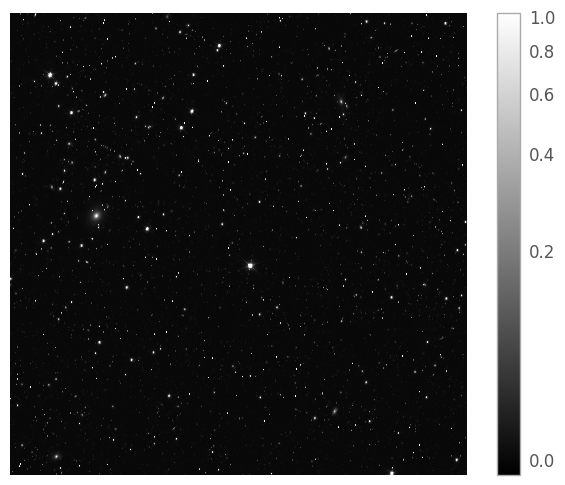

In [10]:
# plotting the image
plt.figure()
plt.imshow(img_data, cmap='gray', origin='lower', norm=ImageNormalize(img_data, interval=PercentileInterval(99.9), stretch=AsinhStretch()))
colorbar = plt.colorbar()
_ = plt.axis('off')

If we don't want to plot the whole image we can also first make a cutout of the source we are interested in with Astropy and plot only that area. Notice that we are giving the cutout function the cutout centre sky coordinates (we want the cutout to be centered on the galaxy so these are the coordinates we found with Simbad earlier), size of the cutout and the world coordinate system (WCS) from the header of the image that contains information about how to link the world and pixel coordinates.

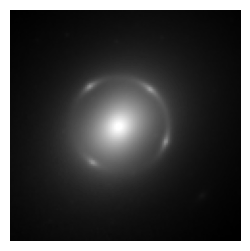

In [11]:
# plotting a cutout of the image
pos_gal = SkyCoord(ra_gal, dec_gal, frame='icrs', unit='deg')
cutout = Cutout2D(data=img_data, position = pos_gal, size= 0.2 * u.arcmin, wcs=wcs.WCS(header))

plt.rcParams['figure.figsize'] = [3,3]
plt.figure()
plt.imshow(cutout.data, cmap='gray', origin='lower', norm=ImageNormalize(cutout.data, interval=PercentileInterval(99.9), stretch=AsinhStretch()))
_ = plt.axis('off')

## 2. Interactive image visualization with Imviz

Imviz is a tool for visualization and analysis of 2D astronomical images. It is a great tool for data exploration because the user can interact with their data from within the tool (moving around in the image, zooming in and out, etc). The functionality has some similarities to the [DS9](https://sites.google.com/cfa.harvard.edu/saoimageds9) programme. The user can for example change basic plot options like (colormap, stretch function and percentile) and look at the image histogram. It is also possile to plot markers around sources from a catalogue or draw markers on the image and then export them. Other functionality includes showing image profiles, performing aperture photometry and overlaying image footprints. If you have any questions when going through the notebook you are welcome to check out the [Imviz documentation](https://jdaviz.readthedocs.io/en/latest/imviz/index.html) for more examples and explanations.

### Creating empty Imviz window

In the following cell we create an Imviz instance and show the (for now) empty window. The viewer can be displayed either in the output of the cell below or alternatively on the side of the notebook (especially helpful when you have a wider screen). Note that everything we do in the code cells beyond this point will update this same display and can also be done by using the buttons in the user interface. Since we are updating the same display please run the cells below one at a time (not "run all"). This way you can look at the viewer after each cell to see the changes and we also make sure that the previous command is completed before sending a new one to Imviz.

In [12]:
imviz = Imviz()

# showing the viewer embedded into this notebook
viewer = imviz.default_viewer
imviz.show()

# showing the viewer on the side of the notebook
# imviz.show('sidecar', height=1000)

<IPython.core.display.Javascript object>

Application(config='imviz', docs_link='https://jdaviz.readthedocs.io/en/v4.1.1/imviz/index.html', events=['cal…

### Loading image data

With the cell below we load the VIS data into the Imviz viewer. This can be done in the interface by using the blue "import data" button at the top left of the viewer. Depending on the file size this may take a few seconds. After loading the data you can go back to the viewer and click the "pan" button to move around in the image and zoom in or out with your mouse. Notice that since the image tile is large it might take a few seconds after zooming in for the image resolution to increase.

In [13]:
# loading VIS image into Imviz
imviz.load_data(file_vis, data_label='vis')

### Basic plot options

With the data loaded we can now try to change some basic plot options like the stretch function, stretch percentile preset and image colormap. These settings can be found in the interface by opening the main menu with the button at the top right and clicking on the section "Plot options". There you can also find the image histogram.

In [14]:
# changing plot options
plot_options = imviz.plugins['Plot Options']
plot_options.stretch_function = 'Arcsinh'
plot_options.stretch_preset = '99%'
plot_options.image_colormap = 'Viridis'

# plot_options.stretch_vmin = 0.05
# plot_options.stretch_vmax = 1.0

### Plotting a catalogue of sources as markers

As the next example we can plot markers around some of the sources. For this we first use astroquery to make a query for some sources from the MER catalogue that are around the centre of our image. More specifically we are looking for sources larger than 10000 pixels with a flux above 20 $\mu Jy$ in a 20 arcminute radious around the centre coordinates of the image. You are welcome to modify the query to change the tresholds to plot different sources.

In [15]:
# query for sources around image centre from catalogue 
img_centre = 267.3875305431, 65.4770427054

query = f"""(SELECT right_ascension, declination, segmentation_area, flux_vis_sersic, ellipticity, kron_radius, segmentation_map_id
        FROM catalogue.mer_catalogue AS mer
        WHERE CONTAINS(POINT('ICRS', mer.right_ascension, mer.declination), CIRCLE('ICRS', {img_centre[0]}, {img_centre[1]}, {20/60})) = 1
        AND mer.segmentation_area > 10000 AND mer.flux_vis_sersic != 'NaN' AND mer.flux_vis_sersic > 20)"""

job = Euclid.launch_job_async(query, verbose=False)
source_results = job.get_results()

# query was for wider area, now keeping only sources within footprint of the image
mask = SkyCoord(source_results['right_ascension'], source_results['declination'], frame='icrs', unit="deg").contained_by(wcs.WCS(header))
source_results = source_results[mask]

source_results

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


right_ascension,declination,segmentation_area,flux_vis_sersic,ellipticity,kron_radius,segmentation_map_id
float64,float64,int64,float64,float64,float64,int64
267.72292868067,65.28166748245759,19415,337.1372375488281,0.12224916368722916,186.5758819580078,102158889010754
267.824368132254,65.28794864918753,14408,581.5877685546875,0.06030748039484024,126.13703155517578,102158889011978
266.99963305880954,65.30434086854648,10649,481.0611877441406,0.03845784813165665,95.8579330444336,102158889015016
267.83577193238847,65.31972013921904,18706,542.4175415039062,0.4891563355922699,228.60107421875,102158889018031
267.3891784441825,65.34845525044362,11662,342.6084289550781,0.04297751933336258,106.33551025390625,102158889023598
266.93524821802833,65.44875919489559,10133,213.03164672851562,0.29974526166915894,148.75807189941406,102158889043329
267.655205091657,65.46196221856555,11880,62.46200180053711,0.4616190195083618,228.5868682861328,102158889046027
266.9066544849443,65.48696852603592,11969,661.1205444335938,0.058570388704538345,112.38414001464844,102158889051024
267.21754640445096,65.5056379353524,12117,530.3604125976562,0.03580876439809799,105.5538101196289,102158889054418


Next we can use the table of sources we obtained and plot some markers around them in the image viewer. We will be using the source table we got as a result of the archive catalogue query but you can also use your own file with sources. Notice that after adding markers to the image, it looks very crowded in the beginning but the visibility gets better once you start zooming in and moving around.

In [16]:
# adding sources to image as markers
viewer.marker = {'color': 'red', 'alpha': 0.8, 'markersize': 1000, 'fill': False}

# in case you have the sources in a file instead then you can first read in the file to an astropy table
# source_results = Table.read('my_catalog.ecsv')

coord_i2d = Table({'coord': [SkyCoord(ra=source_results["right_ascension"],
                                      dec=source_results["declination"],
                                      unit="deg")]})
viewer.add_markers(coord_i2d, use_skycoord=True, marker_name='my_sources')

We can also remove the markers when we are done with them.

In [17]:
# remove only my_sources
viewer.remove_markers(marker_name='my_sources')

# remove all markers
# viewer.reset_markers()

### Working with more images - blinking

In the following section we also load the two NISP images into the viewer. This might take a few seconds. After the data has been loaded we can look at how to modify the plot options for each of the images separately. And then it is possible to blink between all the loaded images by hovering over the image and clicking the b key.

In [18]:
# adding NISP data
imviz.load_data(file_nisp_h, data_label='nisp_h')
imviz.load_data(file_nisp_y, data_label='nisp_y')

# option to align the images by wcs (default is pixels)
# imviz.link_data(align_by='wcs')

In [19]:
# changing nisp_h image options
plot_options.layer = 'nisp_h[PRIMARY,1]'
plot_options.stretch_function = 'Arcsinh'
plot_options.stretch_preset = '99%'

In [20]:
# changing nisp_y image options
plot_options.layer = 'nisp_y[PRIMARY,1]'
plot_options.stretch_function = 'Arcsinh'
plot_options.stretch_preset = '99%'

In [21]:
# in case you want to apply the same plot options to all loaded images/layers
# plot_options.select_all()

### Zooming to specific part of image

If you have a specific part of the image you are interested in then it is possible to programmatically centre the image on those sky coordinates and zoom there as shown below. After running the cell below you can try blinking between the images again to see the galaxy in different bands.

In [23]:
# center the image on given sky coordinates
sky = SkyCoord("17h48m18.89s +65d35m57.26s", frame='icrs')
viewer.center_on(sky)
viewer.zoom_level = 1

### Creating a new window to view side-by-side

In case the user is interested in viewing images side-by-side instead of blinking, it is possible to add another viewer/window to the Imviz instance. The button for doing this in the interface is in the top centre of the viewer. After creating the viewer you can choose in the interface which data to add to it from the images that we already loaded to Imviz.

In [24]:
# adding new viewer to view side-by-side
viewer_2_name = 'Window 2'
viewer_2 = imviz.create_image_viewer(viewer_name=viewer_2_name)

In [25]:
# removing second viewer again
imviz.destroy_viewer(viewer_2_name)

### Loading images with batch load

Before we loaded all the images into the viewer one at a time but to save on performance while loading multiple images you can optionally use batch loading.

In [26]:
# filepaths = ['/data/euclid_q1/Q1_R1/MER/102158890/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158890-A55DC9_20241024T203010.047276Z_00.00.fits',
#             '/data/euclid_q1/Q1_R1/MER/102158890/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102158890-C5905C_20241024T204235.836797Z_00.00.fits',
#             '/data/euclid_q1/Q1_R1/MER/102158890/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158890-70EB47_20241024T204248.973773Z_00.00.fits']

# imviz2 = Imviz()
# with imviz2.batch_load():
#     for filepath in filepaths:
#         imviz2.load_data(filepath)
# imviz2.show()

### Exporting image in viewer as png

It is possible to export the image currently in the viewer using the following command. 

In [27]:
viewer.save(output_folder + 'imviz_image.png')

### Exporting spatial regions

To create a spatial region subset in the viewer, click the button for selecting a circular region of interest (next to the zoom and pan buttons) and click-drag on the image to create the subset. In the cell below we also show how to create regions programmatically and look at how to export regions from the viewer and convert them into an image mask.

In [28]:
#creating the regions manually
aper_1 = CirclePixelRegion(center=PixCoord(x=300, y=400), radius=100)
aper_2 = CirclePixelRegion(center=PixCoord(x=1500, y=3000), radius=200)
imviz.load_regions([aper_1, aper_2])

In [29]:
# exporting created subsets/regions from the viewer
subset_tools = imviz.plugins['Subset Tools']
regions = subset_tools.get_regions()
regions

{}

In [ ]:
# optional: creating and showing a mask of the region (this cell is memory intensive)
# mask = regions['Subset 1'].to_mask(mode='subpixels')
# data = imviz.get_data('vis[PRIMARY,1]')
# _ = plt.imshow(mask.to_image(data.data.shape), origin='lower')

### Exporting markers

This section expects that the user has created some markers in the viewer (that's why it's commented out by default). To do this navigate to the "Markers" section in the main menu. With that open hover your mouse over a source you want to mark and click the m key. You should see a new entry in the marker table. Now that you have some markers you can export that table of marker locations as shown in the cell below.

In [ ]:
# markers_plugin = imviz.plugins["Markers"]
# markers_table = markers_plugin.export_table()
# markers_table.write(output_folder + 'markers.ecsv', overwrite=True)  
# markers_table

### Additional Imviz functionality

The aim of this notebook is to give a short introduction to Imviz, so we did not cover all possible functionality. In case you would like some more detailed examples about the things covered in this notebook or are interested in examples about additional functionality like the ones listed below we encourage you to take a look at the [Imviz documentation](https://jdaviz.readthedocs.io/en/latest/imviz/index.html).

* Viewing file metadata
* Sky rotation
* Compass
* Image profiles
* Aperture photometry
    * Curve of Growth plot
    * Radial Profile plot
    * Exporting photometry results
* Plotting instrument footprint overlays 

## 3. Visualization with Pyesasky

ESASky is a scientific discovery portal that provides full access to the entire sky as observed with space, ground based and multi-messenger astronomy missions. [PyESASky](https://www.cosmos.esa.int/web/esdc/pyesasky#) is an interactive widget allowing users to work with ESASky within a Jupyter notebook and JupyterLab. 

In this section of the notebook we will show you how to import and load the pyESASky instance. We are keeping it short because there is a lot of good supporting material available about working with both ESASky (great [documentation](https://www.cosmos.esa.int/web/esdc/esasky-help) and many [tutorial videos](https://www.cosmos.esa.int/web/esdc/esasky-how-to)) and PyESASky (especially this [series of notebooks](https://github.com/esdc-esac-esa-int/pyesasky/tree/master/examples) to help you get started).

In [30]:
# import the required Python modules:
from pyesasky import ESASkyWidget
from pyesasky.models import Catalogue, CooFrame, ImgFormat, FootprintSet, MetadataType
from pyesasky.descriptors import CatalogueDescriptor, FootprintSetDescriptor, MetadataDescriptor

In [31]:
# instantiate the pyESASky instance
esasky = ESASkyWidget()

Box(children=(VBox(children=(FileChooser(path='/media/user/Q1_notebooks/updates_pdr', filename='', title='Sele…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<IPython.core.display.HTML object>', '…

In [32]:
# load the pyESASky instance
esasky

ESASkyWidget(layout=Layout(align_self='stretch', height='400px'))

***
## Runnning the notebook outside of ESA Datalabs

The current notebook was developed with the intent to use it inside ESA Datalabs, so all the filepaths point to the data volume mounted in ESA Datalabs. It is possible to modify the notebook to run outside of the platform if needed, but there are a few things to consider:

1. You need to install all the packages used in the notebook yourself
2. When trying to access any of the data, the products first need to be downloaded using astroquery (due to the files being large this might take some time which is why using ESA Datalabs is advised)

You can download the product by using the astroquery get_product method as shown below. You can find more information about using the function in the [Astroquery examples notebook](Astroquery.ipynb). After downloading the image you can run the rest of the notebook by substituting the ESA Datalabs file path(s) set in the beginning of the notebook with the one(s) you set on you local machine.

`example_filename = EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits`
`Euclid.get_product(file_name=example_filename.fits, output_file=output_folder + 'local_file_name.fits')`